# Домашнее задание

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                                precision_recall_curve, confusion_matrix, roc_curve, roc_auc_score, log_loss
import xgboost as xgb
import lightgbm as lgb

__1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта__

__2. при обучении моделей обязательно использовать кроссвалидацию__

In [2]:
df = pd.read_csv("C:\\Users\\tanbe\\Desktop\\train_case2.csv", ";")
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [5]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [6]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [7]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc_score_ = roc_auc_score(y_test, y_score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc_score_
                                                                       ))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838, ROC_AUC=0.784


In [8]:
def plot_roc_auc(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

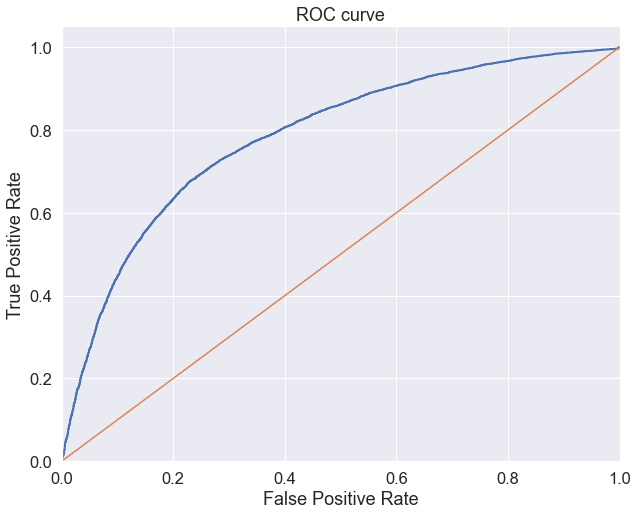

In [9]:
plot_roc_auc(y_test, y_score)

In [10]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230668


In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Будем выводить тип матрицы только в заголовке и округлять нормализованные значения
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 6)
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix'
        

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Уберем сетку
    plt.grid(False)
    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

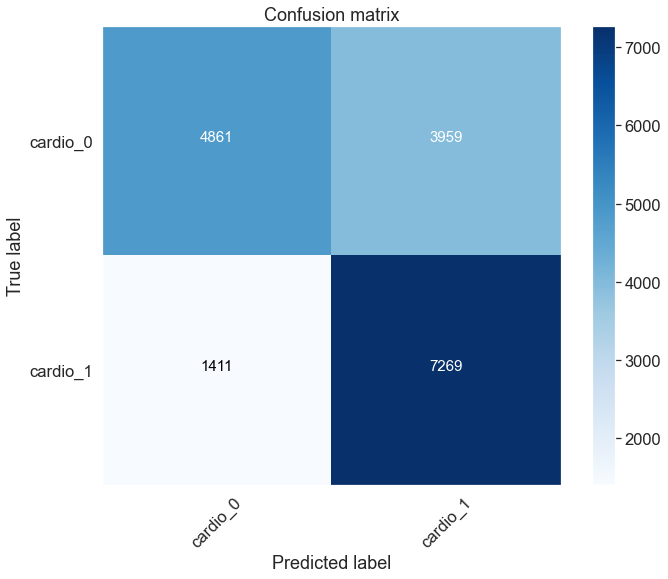

In [12]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [13]:
df = pd.DataFrame(columns=['model', 'roc_auc', 'precision', 'recall', 'f_score'])
df = df.append({'model': 'LogisticRegression', 'roc_auc': roc_auc_score_, 'precision': precision[ix],\
                'recall': recall[ix], 'f_score': fscore[ix]}, ignore_index=True)
df

,model,roc_auc,precision,recall,f_score
0,LogisticRegression,0.784035,0.647431,0.837558,0.730323


# XGBoost

In [14]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 42, use_label_encoder=False, objective='binary:logistic')),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score_xgb = classifier.predict_proba(X_test)[:, 1]

[16:03:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [15]:
b=1
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test.values, y_score_xgb)
fscore_xgb = (1+b**2)*(precision_xgb * recall_xgb) / (b**2*precision_xgb + recall_xgb)
# locate the index of the largest f score
ix_xgb = np.argmax(fscore_xgb)
roc_auc_score__xgb = roc_auc_score(y_test, y_score_xgb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds_xgb[ix_xgb], 
                                                                        fscore_xgb[ix_xgb],
                                                                        precision_xgb[ix_xgb],
                                                                        recall_xgb[ix_xgb],
                                                                        roc_auc_score__xgb
                                                                       ))

Best Threshold=0.347103, F-Score=0.738, Precision=0.665, Recall=0.828, ROC_AUC=0.797


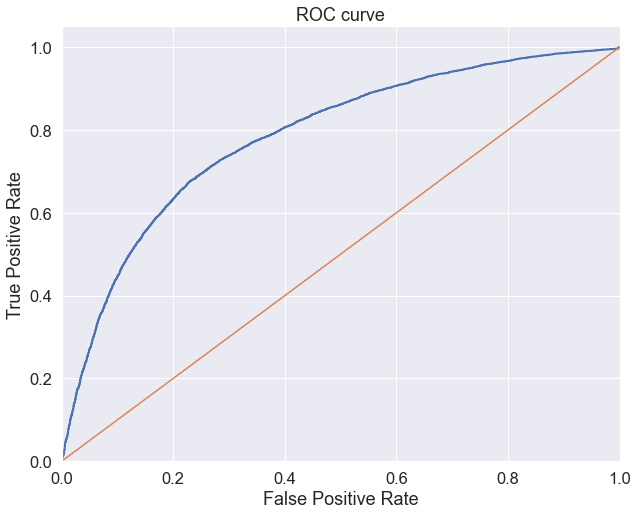

In [16]:
plot_roc_auc(y_test, y_score)

In [17]:
df = df.append({'model': 'XGBoost', 'roc_auc': roc_auc_score__xgb, 'precision': precision_xgb[ix_xgb],\
                'recall': recall_xgb[ix_xgb], 'f_score': fscore_xgb[ix_xgb]}, ignore_index=True)
df

,model,roc_auc,precision,recall,f_score
0,LogisticRegression,0.784035,0.647431,0.837558,0.730323
1,XGBoost,0.797228,0.665248,0.828341,0.737890


# Случайный лес

In [18]:
classifier_rf = Pipeline([
#     ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_rf, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_rf.fit(X_train, y_train)
y_score_rf = classifier_rf.predict_proba(X_test)[:, 1]

CV score is 0.7867706416947285+-0.00859863014690675


In [19]:
b=1
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test.values, y_score_rf)
fscore_rf = (1+b**2)*(precision_rf * recall_rf) / (b**2*precision_rf + recall_rf)
# locate the index of the largest f score
ix_rf = np.argmax(fscore_rf)
roc_auc_score__rf = roc_auc_score(y_test, y_score_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds_rf[ix_rf], 
                                                                        fscore_rf[ix_rf],
                                                                        precision_rf[ix_rf],
                                                                        recall_rf[ix_rf],
                                                                        roc_auc_score__rf
                                                                       ))

Best Threshold=0.340000, F-Score=0.728, Precision=0.643, Recall=0.840, ROC_AUC=0.784


In [20]:
df = df.append({'model': 'Random Forest', 'roc_auc': roc_auc_score__rf, 'precision': precision_rf[ix_rf],\
                'recall': recall_rf[ix_rf], 'f_score': fscore_rf[ix_rf]}, ignore_index=True)

__3. вывести сравнение полученных моделей по основным метрикам классификации:__

__4. сделать выводы о том, какая модель справилась с задачей лучше других__

In [21]:
df

,model,roc_auc,precision,recall,f_score
0,LogisticRegression,0.784035,0.647431,0.837558,0.730323
1,XGBoost,0.797228,0.665248,0.828341,0.737890
2,Random Forest,0.784304,0.642756,0.840323,0.728380


Лучше всего справилась модель XGBoost